## Import Cleaned Data

__DataFrames:__  
df_model - df with all the features (independent festures + Target)  
x - df with all independent features
y - df with dependent feature  
x_train - df with training data from x  
x_train_out - df with training data from x with outliers treatment applied  
x_test - df with test data from x  
x_test_out - df with test data from x with outliers treatment applied  



d:\Rafael\Anaconda_Setup\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
d:\Rafael\Anaconda_Setup\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
d:\Rafael\Anaconda_Setup\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


CAPM
Import data from: ..\..\..\SampleData\Sample\LongTerm-DataPreparation_Skew.csv
Original CAPM is being used as Target
Nr of rows:
72538


<Figure size 432x288 with 0 Axes>

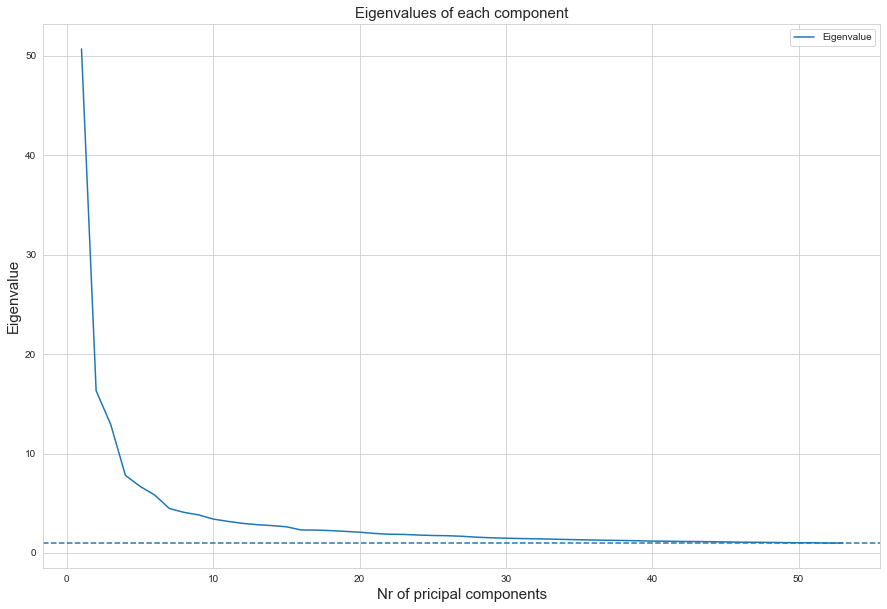

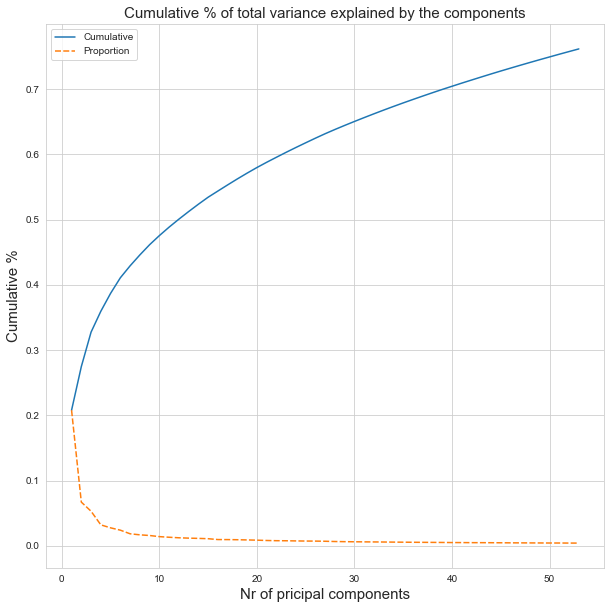

The variance explained by each component is: [50.70262543 16.3180414  12.90616231  7.80559243  6.69692605  5.82614766
  4.47015907  4.07836541  3.82626867  3.40508117  3.17395217  2.97398597
  2.84255924  2.7491931   2.6284572   2.30920491  2.29580116  2.24676716
  2.1685526   2.08344875  1.96058327  1.88331954  1.85945512  1.79999003
  1.75303096  1.72999438  1.67342676  1.57892838  1.52235707  1.48115797
  1.44613583  1.42029951  1.39091026  1.35520895  1.32448072  1.29342424
  1.27059382  1.25051426  1.2247642   1.18608517  1.17810508  1.15156743
  1.14454538  1.12935887  1.10669478  1.0815426   1.07222534  1.05458183
  1.03848544  1.01988948  1.01877496  0.99533768  0.98807987]
The total variance explained by the components is: 0.7618344466001962


In [1]:
import sys
sys.path.insert(1, r'C:\Users\rafae\Personal\Github\Functions\Data-Science-Functions')
sys.path.insert(2, r'C:\Users\rafae\Personal\Github\Functions\Data-Science-Functions\Functions')
sys.path.insert(3, r'..\..\..')


import Classification_CV as class_cv
import importCleanedData as importData
import importSubsets as subsets

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from tensorflow import keras

import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

#set preferences
sns.set_style('whitegrid')

#set color for graphs
#set color for graphs
palette = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3"]

# dir = r'C:\Users\rafae\Personal\Github\Asset-Allocation\Long-Term-CAPM\SampleData\Sample'
dir = r'..\..\..\SampleData\Sample'
df_model_skew,df_target = importData.importCleanedData(dir=dir,target='CAPM')


#split data
date = '2018-01-01'
#split data without transformation
x_train,x_train_out,x_test, x_test_out,y_train_dict ,y_test_dict, y_train,y_test = importData.splitData(df_model_skew, date) 

#set columns
ratio_cols = df_model_skew.columns[(df_model_skew.columns.str.contains('Ratio'))]
shares_cols = df_model_skew.columns[(df_model_skew.columns.str.contains('Share'))]
margin_cols = df_model_skew.columns[(df_model_skew.columns.str.contains('Margin'))]
turnover_cols = df_model_skew.columns[(df_model_skew.columns.str.contains('Turnover'))]
dividend_cols = df_model_skew.columns[(df_model_skew.columns.str.contains('dividend'))]


components_pca, pca_components_test = importData.runPCA(x_train_out= x_train_out,x_test = x_test)


#import subsets
lasso_subset_0, lasso_subset_15, mi_subset_0, mi_subset_15, lgb_subset, corr_subset0, corr_subset15 = subsets.importSubsets()


subset_0, subset_15 = lasso_subset_0, lasso_subset_15

# Train Models with MI subset with outliers present

In [2]:
def gen_NNClassification (x, y, hidden_layer_sizes,activation_list, dropout,optimizer,loss = 'BinaryCrossentropy', metrics = ['AUC'],batch_size=180,epochs=10,validation_split = 0.25, class_weight = None, output_bias =None ):
    
    print('Neural Network Parameters:')
    print(f'Optimizer: {optimizer}')
    print(f'Loss: {loss}')
    print(f'Hidden Layer tructure: {hidden_layer_sizes}')
    print(f'Acivation Functions: {activation_list}')
    print(f'Dropout: {dropout}')
    print(f'Class Weight: {class_weight}')
    print(f'Output Bias: {output_bias}')
    
    #import libraries
    from scikeras.wrappers import KerasClassifier, KerasRegressor
    from tensorflow import keras
    reset_random_seeds()
    #get nr features in
    n_features_in_ = x.shape[1]
    n_classes_ = len(y.unique())
    
    if output_bias is not None:
        output_bias =keras.initializers.Constant(output_bias)
    
    #set keras model
    model = keras.models.Sequential()
    
    #define input shape
    # model.add(keras.layers.Input(shape=(n_features_in_,)))
    model.add(keras.layers.Dense(
          4, activation='relu',
          input_shape=(n_features_in_,)))
    
    #define hidden layers
    for hidden_layer_size, activation_ in zip(hidden_layer_sizes,
                                              activation_list):
        
        model.add(keras.layers.Dense(hidden_layer_size,
                                     activation=activation_))
        
        model.add(keras.layers.Dropout(dropout))
    
    #define output layer
    model.add(keras.layers.Dense(1,
                                 activation="sigmoid",
                                 bias_initializer=output_bias))
    
    #compile model 
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=metrics,
                  )
    
    #transform to SKlearn format
    NNmodel = KerasClassifier( model=model,
                            batch_size= batch_size,
                            epochs= epochs,
                            class_weight=class_weight,
                            validation_split=validation_split,
                            loss = loss)

    return NNmodel

metrics = ['AUC','Recall','Precision']


def reset_random_seeds():
    import random
    from numpy.random import seed
    import os
    import numpy as np 
    from tensorflow import random as r
    
    seed_nr = 0
    os.environ['PYTHONHASHSEED']=str(seed_nr)
    r.set_seed(seed_nr)
    np.random.seed(seed_nr)

from numpy.random import seed
from tensorflow import keras 


reset_random_seeds()
optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
loss_ = keras.losses.BinaryCrossentropy()
NNmodel = gen_NNClassification(x_train_out[mi_subset_15], 
                                 y_train_dict['Target_0.15'],
                                 hidden_layer_sizes = (50,),
                                 activation_list = ['relu'],
                                 dropout = 0.3,
                                 optimizer =optimizer ,
                                 loss = loss_, 
                                 metrics = metrics,
                                 batch_size=64,
                                 epochs=15,
                                 validation_split = 0.25,
                                 class_weight = 'balanced',
                                 output_bias =None )



def roc_curve (models,names,X_train,y_train, X_val, y_val):
    ''''''''''''''''
    Compares different models using stratified k fold for classification problems
    Receives:
        list with model names and a list of models 
        x_train (independent variables) and y_train (dependent variable)
        x_test (independent variables) and y_test (dependent variable)   
        
    Displays ROC curve of the respective models 
    
    '''''''''''''''
    
    names= names
    from sklearn.metrics import roc_curve
    sns.set_theme(style = 'whitegrid')
    plt.figure(figsize = (10,10))
    for i, names ,in zip(models,names):
        # i.fit(X_train,y_train)
        thresh_dict = {}
        prob_model = i.predict_proba(X_val)
        
        fpr_DT_ent, tpr_DT_ent, thresholds_DT_ent = roc_curve(y_val, prob_model[:,1])
        plt.plot(fpr_DT_ent, tpr_DT_ent, label=f"ROC Curve {names}" , )
        
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.legend()
        
    
    
def precision_recall_curve (model,names, X_train,y_train,X_val,y_val):
    ''''''''''''''''
    Compares different models using stratified k fold for classification problems
    Receives:
        model and respective name (string)
        x_train (independent variables) and y_train (dependent variable)
        x_test (independent variables) and y_test (dependent variable)   
        
    Displays Precision - Recall  curve of the respective models 
    Note: the model is fitted inside the function 
    
    '''''''''''''''
    names=names
    model.fit(X_train,y_train)
    proba = model.predict_proba(X_val)
    from sklearn.metrics import precision_recall_curve
    precision, recall, thresholds = precision_recall_curve(y_val, proba[:,1])

    # apply f1 score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
    
    plt.figure(figsize = (10,10))
    plt.plot(recall, precision, marker='.', label=f'{names}')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()
    
    
def fitted_precision_recall_curve (model,names, X_train,y_train,X_val,y_val):
    ''''''''''''''''
    Compares different models using stratified k fold for classification problems
    Receives:
        model and respective name (string)
        x_train (independent variables) and y_train (dependent variable)
        x_test (independent variables) and y_test (dependent variable)   
        
    Displays Precision - Recall  curve of the respective models 
    Note: the model is fitted outside the function 
    
    '''''''''''''''
    names=names
    #model.fit(X_train,y_train)
    proba = model.predict_proba(X_val)
    from sklearn.metrics import precision_recall_curve
    precision, recall, thresholds = precision_recall_curve(y_val, proba[:,1])

    # apply f1 score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
    plt.figure(figsize = (10,10))
    plt.plot(recall, precision, marker='.', label=f'{names}')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

def assessTest (x_test, y_test, model):
    
    col = x_test.columns[4]
    index__ = x_test.reset_index()[['symbol','fillingDate',col]].set_index(['symbol','fillingDate'])
    target_copy = df_target.copy()
    target_copy['fillingDate'] = target_copy['fillingDate'].astype(str)
    target_copy = target_copy.drop_duplicates(['symbol','fillingDate']).set_index(['symbol','fillingDate'])
    target_copy = target_copy.loc[target_copy.index.isin(index__.index)]
    
    assess_test_dict = dict()
    pred_test = model.predict(x_test)
    assess_test = pd.DataFrame(index = y_test.index)
    assess_test['Prediction'] = pred_test
    assess_test['Target'] = y_test
#     assess_test['returns'] = df_model.loc[df_model.index.isin(y_test.index),'futReturns']
    assess_test['excReturns'] = target_copy.loc[target_copy.index.isin(index__.index),'futAlpha']

    avg_returns = assess_test.groupby('Prediction').mean()[['excReturns']]


    from sklearn.metrics import roc_auc_score, precision_score, recall_score,accuracy_score
    auc  = roc_auc_score(assess_test['Target'],assess_test['Prediction'] )
    precision = precision_score(assess_test['Target'],assess_test['Prediction'] )
    recall =  recall_score(assess_test['Target'],assess_test['Prediction'] )
    acc =  accuracy_score(assess_test['Target'],assess_test['Prediction'] )
    
    assess_test_dict['accuracy'] = acc
    assess_test_dict['auc'] = auc
    assess_test_dict['precision'] = precision
    assess_test_dict['recall'] = recall
    return(assess_test_dict,assess_test)

Neural Network Parameters:
Optimizer: <keras.optimizers.optimizer_experimental.rmsprop.RMSprop object at 0x0000017A48F74A30>
Loss: <keras.losses.BinaryCrossentropy object at 0x0000017A22D06790>
Hidden Layer tructure: (50,)
Acivation Functions: ['relu']
Dropout: 0.3
Class Weight: balanced
Output Bias: None


## Target 0.15

Perfomance is compared using using standardized data since Neural Networks and Logistic Regressions are highly affected by data scalling.

In [4]:
def assessModels (x_train,y_train,x_test,y_test,model_list, model_names,):
    import joblib
    #set path to store models
    model_path = r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Target_15\Models\Raw\MI\\'
    
    new_model_list = []
    test_assess_list = []
    
    full_assess = pd.DataFrame()
    full_assess_test = pd.DataFrame()
    predictions_df = pd.DataFrame()
    #iterate over the models and perform CV 
    for model, name in zip(model_list, model_names):
        assess = class_cv.validateModel(x_train,
                                        y_train,
                                        model=model ,
                                        scaler=True ,
                                        over_sampling=False,
                                        predictions=True,
                                        cv_type='stratKfold',
                                        scaler_type='stand',
                                        train_size=10,
                                        test_size=1,
                                        gap=0)
        
        
        #store scores
        assess_df = assess['scores']
        assess_df['model'] = name
        
        full_assess = pd.concat([full_assess,
                                assess_df],
                                axis=0)
        
        
        predictions = assess['predictions']
        predictions['model'] = name
        predictions_df = pd.concat([predictions_df,predictions],
                                axis=0)
        
        #store model 
        model = assess['model']
        new_model_list.append(model)
        
        
        new_model_name = name + '.pkl'
        # joblib.dump(model, f'{model_path}{new_model_name}', compress=9)
        
        if name =='LightGB':
            features = model.feature_name_
    
        elif name =='Keras_NN':
            features = features
        
        else:
            features = model.feature_names_in_
            
        
        scaler = assess['scaler']
        scale_features = scaler.get_feature_names_out()
    
        rest_ft =[]
        for ft in features:
            if ft not in scale_features:
                rest_ft.append(ft)
    
    
    
        # fit scaler on test set 
        X_test = pd.DataFrame(scaler.transform(x_test[scale_features]), 
                            index = x_test.index, 
                            columns = scale_features)
        
        X_test = pd.concat([X_test, x_test[rest_ft]],axis=1)
            
        
        X_test = X_test[features]
        
        assess_test_dict, assess_test_df = assessTest(X_test,
                                                    y_test,
                                                    model)
        assess_test_dict['model'] = name
        assess_test_df['model'] = name
        
        full_assess_test = pd.concat([full_assess_test,
                                assess_test_df],
                                axis=0)
        test_assess_list.append(assess_test_dict)
        
    test_assess_df = pd.DataFrame.from_records(test_assess_list)
    
    scaler_name = 'scaler.pkl'
    # joblib.dump(scaler, f'{model_path}{scaler_name}', compress=9)
    
    return(full_assess,test_assess_df,new_model_list ,predictions_df)

In [11]:
#set models
dt_model = DecisionTreeClassifier(class_weight='balanced',
                                  max_depth=6,
                                  max_features=9,
                                  min_samples_leaf=10,
                                  random_state=0)


lgb_model = lgb.LGBMClassifier(boosting_type='dart',
                               class_weight='balanced',
                               learning_rate=0.2,
                               max_depth=2, 
                               n_estimators=50,
                               random_state=0)

lr_model = LogisticRegression(class_weight='balanced',
                              penalty=None,
                              random_state=0,
                   solver='newton-cholesky')


model_list = [lr_model,dt_model, lgb_model,NNmodel]
model_names = ['LogisticRegression','DecisionTree','LightGB','Keras_NN']

full_assess,test_assess_df,new_model_list, predictions_df = assessModels(x_train[mi_subset_15],y_train_dict['Target_0.15'],
                                                            x_test[mi_subset_15],y_test_dict['Target_0.15'],
                                                            model_list[:],
                                                            model_names[:])

stratKfold
Nr of splits: 10
Scalling will be performed at each iteration
Scaler type: stand
accuracy_train     0.632169
f1_train           0.328095
recall_train       0.632159
precision_train    0.221547
auc_train          0.632165
accuracy_test      0.628172
f1_test            0.327177
recall_test        0.620064
precision_test     0.228062
auc_test           0.624791
dtype: float64
stratKfold
Nr of splits: 10
Scalling will be performed at each iteration
Scaler type: stand
accuracy_train     0.584968
f1_train           0.336176
recall_train       0.739477
precision_train    0.217642
auc_train          0.649433
accuracy_test      0.571486
f1_test            0.320400
recall_test        0.695723
precision_test     0.211204
auc_test           0.623321
dtype: float64
stratKfold
Nr of splits: 10
Scalling will be performed at each iteration
Scaler type: stand
accuracy_train     0.592230
f1_train           0.333643
recall_train       0.718525
precision_train    0.217288
auc_train          0.6

INFO:tensorflow:Assets written to: C:\Users\rafae\AppData\Local\Temp\tmpe5rb1x07\assets


INFO:tensorflow:Assets written to: C:\Users\rafae\AppData\Local\Temp\tmpe5rb1x07\assets


312/312 [==============================] - 0s 1ms/step


#### Train NN with Random Under Sampling

In [24]:
from sklearn.neural_network import MLPClassifier

#set NN model
nn_model = MLPClassifier(activation='logistic', batch_size=512, learning_rate='invscaling',
              learning_rate_init=0.1, max_iter=10, random_state=0,
              solver='sgd')
name = 'MLP'
#run NN CV with under sampling
assess = class_cv.validateModel(x_train[mi_subset_15],
                                y_train_dict['Target_0.15'],
                                model=nn_model ,
                                scaler=True ,
                                over_sampling=False,
                                under_sampling=True,
                                predictions=True,
                                cv_type='stratKfold',
                                scaler_type='stand',
                                train_size=10,
                                test_size=1,
                                gap=0)

#store scores
assess_df = assess['scores']
assess_df['model'] = name

#store predictions
predictions = assess['predictions']
predictions['model'] = name
predictions_df = pd.concat([predictions_df,predictions],
                        axis=0)

#store model 
model = assess['model']
new_model_list.append(model)

#set scaler
scaler = assess['scaler']

if name =='LightGB':
        features = model.feature_name_
        
else:
    features = model.feature_names_in_
scale_features = scaler.get_feature_names_out()
 
rest_ft =[]
for ft in features:
    if ft not in scale_features:
        rest_ft.append(ft)

#store scores
full_assess_ = pd.concat([full_assess,
                            assess_df],
                        axis=0)

#fit scaler on test set 
X_test = pd.DataFrame(scaler.transform(x_test[scale_features]), 
                        index = x_test.index, 
                        columns = scale_features)

#format test set
X_test = pd.concat([X_test, x_test[rest_ft]],axis=1)
X_test = X_test[features]

#assess test set
assess_test_dict, assess_test_df = assessTest(X_test,
                                                y_test_dict['Target_0.15'],
                                                model)
assess_test_dict['model'] = name
assess_test_df['model'] = name


stratKfold
Nr of splits: 10
Scalling will be performed at each iteration
Scaler type: stand
Undersampling will be performed:
Strategy: Random Undersampling
accuracy_train     0.626557
f1_train           0.633060
recall_train       0.644272
precision_train    0.622236
auc_train          0.626557
accuracy_test      0.615294
f1_test            0.324790
recall_test        0.638410
precision_test     0.220935
auc_test           0.624940
dtype: float64


### Plot Perfomance 

In [28]:
full_assess['subset'] = 'MI - Outliers'

path = r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Target_15\Validation\Full_Validation\full_CV_results_MI_Raw.csv'
full_assess.to_csv(path)

#### Boxplot Format A

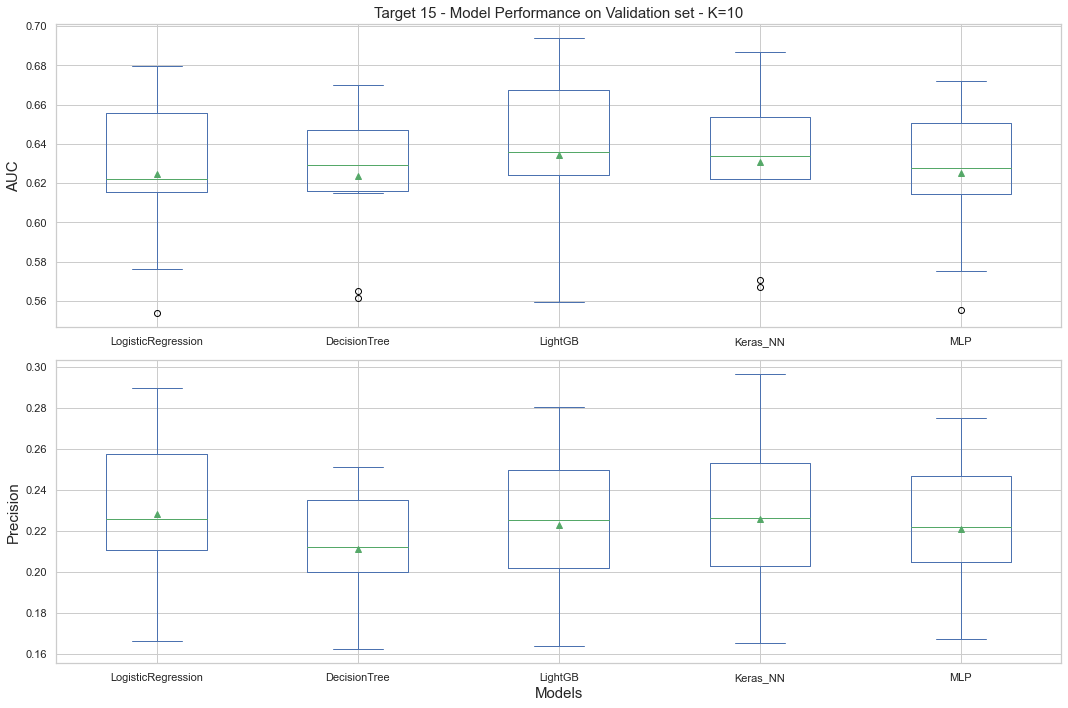

In [29]:
a = full_assess.copy()

title = 'Target 15 - Model Performance on Validation set - K=10'
plt.figure(figsize=(15, 10))
ax1 = plt.subplot(2, 1, 1)
df_assess = pd.DataFrame()
for model in a.model.unique():
    df_assess[model] = a.loc[a['model']==model,'auc_test'].values
df_assess.plot(kind='box', title='boxplot', showmeans=True,ax=ax1)
ax1.set_title(title, size=15)
ax1.set_xlabel('', size=15)
ax1.set_ylabel('AUC', size=15)


ax2 = plt.subplot(2, 1, 2, ) # Share x-axis ticks with ax1
df_assess = pd.DataFrame()
for model in a.model.unique():
    df_assess[model] = a.loc[a['model']==model,'precision_test'].values
df_assess.plot(kind='box', showmeans=True,ax=ax2)

ax2.set_xlabel('Models', size=15)
ax2.set_ylabel('Precision', size=15)
plt.tight_layout()

path = r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Target_15'
name_plot = f'{path}\\{title}-MI.png'
# plt.savefig(name_plot, dpi=300)
plt.show()

#### Display Training and Valdation Results

Export average scores from the Cross Validation

In [31]:
train_val_scores = full_assess.groupby('model').mean()
cols_ = train_val_scores.columns[train_val_scores.columns.str.contains('test')]
for col in cols_:
    
    new_col = col.replace('test','val')
    train_val_scores = train_val_scores.rename(columns = {col:new_col})
    
assess_path = r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Target_15\Validation\modelMetricPerfomance_Target_0.15_valSet_MI_Raw.csv'
train_val_scores.to_csv(assess_path)
display(train_val_scores)

,accuracy_train,f1_train,recall_train,precision_train,auc_train,accuracy_val,f1_val,recall_val,precision_val,auc_val
model,,,,,,,,,,
DecisionTree,0.584968,0.336176,0.739477,0.217642,0.649433,0.571486,0.320400,0.695723,0.211204,0.623321
Keras_NN,0.606658,0.333911,0.693897,0.219953,0.643056,0.600495,0.330210,0.673384,0.225875,0.630910
LightGB,0.592230,0.333643,0.718525,0.217288,0.644923,0.589804,0.332317,0.696536,0.222867,0.634337
LogisticRegression,0.632169,0.328095,0.632159,0.221547,0.632165,0.628172,0.327177,0.620064,0.228062,0.624791
MLP,0.626557,0.633060,0.644272,0.622236,0.626557,0.615294,0.324790,0.638410,0.220935,0.624940


Export scores on test set

In [32]:
test_assess_df = test_assess_df.reset_index().set_index('model')
assess_path = r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Target_15\Test\modelMetricPerfomance_Target_0.15_testSet_MI_Raw.csv'
test_assess_df.to_csv(assess_path)
display(test_assess_df)

,index,accuracy,auc,precision,recall
model,,,,,
LogisticRegression,0,0.692208,0.624588,0.230769,0.531341
DecisionTree,1,0.636018,0.622042,0.211185,0.602770
LightGB,2,0.623047,0.630914,0.212041,0.641764
Keras_NN,3,0.667117,0.624597,0.221572,0.565962


#### ROC Curve Comparison

312/312 [==============================] - 0s 1ms/step


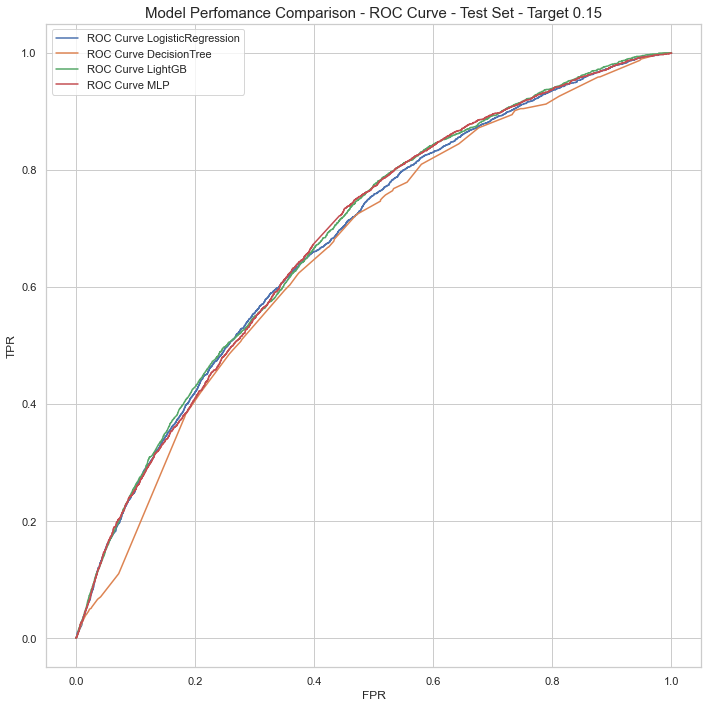

In [33]:
import DataScalling as scalling
model_names = ['LogisticRegression','DecisionTree','LightGB','MLP']
roc_curve(models = new_model_list,
                       names = model_names, 
                       X_train = X_test[features],
                       y_train  = X_test,
                       X_val = X_test[features],
                       y_val= y_test)

title = 'Model Perfomance Comparison - ROC Curve - Test Set - Target 0.15'
plt.title(title, 
          size = 15)
path = r'D:\Utilitários\Facul\Mestrado\2o Ano\Research\Thesis\Tables\Target_15'
name_plot = f'{path}\\{title} - MI.png'
plt.tight_layout()
# plt.savefig(name_plot, dpi=300)